In [1]:
import numpy as np


In [8]:

class AntColonyOptimization:

    def __default_h_calc(self, dist_mtx: np.ndarray) -> np.ndarray:
        heuristic_mtx = np.ones_like(dist_mtx, dtype=np.float64)
        nonzero_indices = dist_mtx > 0.0

        heuristic_mtx[nonzero_indices] /= dist_mtx[nonzero_indices]

        for i in range(dist_mtx.shape[0]):
            heuristic_mtx[i][i] = 0

        return heuristic_mtx

    def __init__(self,
                 dist_mtx: np.ndarray,
                 demand,
                 max_cap,
                 n_nodes,
                 n_ants: int,
                 plot_function,
                 max_it: int = 100,
                 evaporation_rate: float = 0.1,
                 alpha: float = 1.0,
                 betha: float = 1.0,
                 heuristic_calc_func=None,
                 verbose=False
                ) -> None:
        self.dist_mtx = dist_mtx
        self.n_ants = n_ants
        self.max_it = max_it
        self.evapr = evaporation_rate
        self.alpha = alpha
        self.betha = betha
        self.verbose = verbose
        self.plot_function = plot_function
        self.demand = np.array(demand)
        self.max_cap = max_cap
        self.n_nodes = n_nodes
        self.pending_customers_all = set(range(self.n_nodes))

        self.heuristic_calc_func = self.__default_h_calc
        if heuristic_calc_func is not None:
            self.heuristic_calc_func = heuristic_calc_func

        self.pher_mxt = None
        self.hstc_mtx = None
        self.best_ant = None
        self.best_ant_length = None

    def __init_var(self):
        self.hstc_mtx = self.__default_h_calc(self.dist_mtx)
        self.pher_mxt = np.ones_like(self.dist_mtx) * 0.01
        #self.best_ant = np.zeros((self.dist_mtx.shape[0]))
        
    def test_print(self):
        print(self.hstc_mtx)
        print(self.pher_mxt)

    def solve(self):
        self.__init_var()
        ant_path_len = np.zeros((self.n_ants))
        ant_paths = []
        
        for k in range(self.max_it):
            for i in range(self.n_ants):
                ant_path = []
                ant_path.append(0)
                ant_capacity = self.max_cap
                pending_customers = set(range(self.n_nodes))
                pending_customers.remove(0)
                j = 1 #current path position
                while len(pending_customers)>0:
                    #print("j: ",j)
                    probs, flag = self.__move_prob(ant_path[:j], int(ant_path[j - 1]),ant_capacity )
        
                    #print("probs ", probs)
                    #input("Press Enter to continue...")
                    if  flag == 0:
                        ant_path.append(0)
                        ant_capacity = self.max_cap
                    else:
                        ant_path.append( np.random.choice(np.arange(self.dist_mtx.shape[0]), p=probs) )
                        pending_customers.remove(ant_path[j])
                        ant_capacity -= self.demand[ant_path[j]]
                    j = j+1
                
                if ant_path[j-1] != 0: #returns to origin
                    ant_path.append(0) 

                ant_path_len[i] = self.__path_len(ant_path)

                if (self.best_ant_length == None) or ant_path_len[i] < self.best_ant_length:
                    self.best_ant = ant_path.copy()
                    self.best_ant_length = ant_path_len[i]

                self.__update_pheromones(ant_path, ant_path_len[i])

            self.pher_mxt *= (1.0 - self.evapr)

            if k%10 and self.verbose == True:
                print("it: ",k)
                self.plot_function(self)

        return self.best_ant, self.best_ant_length  

    def __move_prob(self, visited, current, ant_capacity):
        #print("vis: ", visited)
        #print("curr: ", current)
        
        pheromones = np.copy(self.pher_mxt[current])
        #print("pher size ", len(pheromones))
        heuristics = self.hstc_mtx[current]

        # Cast the values in 'visited' to integers and set corresponding pheromones to 0
        visited_indices = np.array(visited, dtype=np.int64)
        #print("visited indices",visited_indices )
        #print("ant_capacity ",ant_capacity )
        #print("demand ",self.demand )
        pheromones[visited_indices] = 0
        
        #infalible indices
        infalible_indices = np.where( (ant_capacity - self.demand) < 0)[0]
        #print("infalible_indices ",infalible_indices )
        pheromones[infalible_indices] = 0

        probabilities = pheromones ** self.alpha * heuristics ** self.betha
        den = np.sum(probabilities)
        #print("pher ", pheromones)
        #print("heuristics ", heuristics)
        #print("den ", den)
        if den == 0:
            return (0 , 0)
        probabilities = probabilities / den
        return (probabilities, 1)

    def __path_len(self, path):
        length = 0
        for i in range(len(path) - 1):
            length += self.dist_mtx[int(path[i])][int(path[i + 1])]
        return length

    def __update_pheromones(self, path, length):
        for i in range(len(path) - 1):
            self.pher_mxt[int(path[i])][int(path[i + 1])] += 1.0 / length
            self.pher_mxt[int(path[i + 1])][int(path[i])] += 1.0 / length

In [9]:
class CVRPInstance:
    def __init__(self):
        self.name = ""
        self.num_trucks = 0
        self.dimension = 0
        self.capacity = 0
        self.depot_x = 0
        self.depot_y = 0
        self.customer_demands = []
        self.customer_x = []
        self.customer_y = []
        self.distances = []

def read_cvrp_instance(file_path):
    instance = CVRPInstance()

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Parsing basic information
        instance.name = lines[0].split(":")[1].strip()

        # Extracting the number of trucks from the comment
        comment_parts = lines[1].split(",")
        for part in comment_parts:
            print("part", part)
            if "No of trucks" in part:
                instance.num_trucks = int(part.split()[-1])
                break

        instance.dimension = int(lines[3].split(":")[1])
        instance.capacity = int(lines[5].split(":")[1])

        # Parsing depot coordinates
        instance.depot_x, instance.depot_y = map(float, lines[7].split()[1:])

        # Parsing customer information
        for line in lines[7:7+ instance.dimension]:
            if line.startswith("DEMAND_SECTION"):
                break
            _, x, y = map(float, line.split())
            instance.customer_x.append(x)
            instance.customer_y.append(y)

        for line in lines[7 + instance.dimension+1:7 + instance.dimension+1+ instance.dimension]:
            if line.startswith("DEPOT_SECTION"):
                break
            _, demand = map(int, line.split())
            instance.customer_demands.append(demand)
            
        # Calculate distances based on Euclidean distance
        instance.distances = np.zeros((instance.dimension, instance.dimension))
        for i in range(instance.dimension):
            for j in range(instance.dimension):
                instance.distances[i][j] = np.sqrt((instance.customer_x[i] - instance.customer_x[j])**2 +
                                                  (instance.customer_y[i] - instance.customer_y[j])**2)

    return instance

# Example usage
file_path = "Vrp-Set-A\A\A-n32-k5.vrp"
cvrp_instance = read_cvrp_instance(file_path)

# Accessing instance attributes
print("Name:", cvrp_instance.name)
print("Number of Trucks:", cvrp_instance.num_trucks)
print("Dimension:", cvrp_instance.dimension)
print("Capacity:", cvrp_instance.capacity)
print("Depot coordinates:", (cvrp_instance.depot_x, cvrp_instance.depot_y))
print("Customer demands:", cvrp_instance.customer_demands)
print("Customer distances:", cvrp_instance.distances[0])
print("Customer coordinates:", list(zip(cvrp_instance.customer_x, cvrp_instance.customer_y)))

print( cvrp_instance.distances.shape[0])


part COMMENT : (Augerat et al
part  No of trucks: 5
Name: A-n32-k5
Number of Trucks: 5
Dimension: 32
Capacity: 100
Depot coordinates: (82.0, 76.0)
Customer demands: [0, 19, 21, 6, 19, 7, 12, 16, 6, 16, 8, 14, 21, 16, 3, 22, 18, 19, 1, 24, 8, 12, 4, 8, 24, 24, 2, 20, 15, 2, 14, 9]
Customer distances: [  0.          34.92849839  77.87810989  75.58438992  97.5807358
  54.5710546   51.88448708  37.05401463  85.60373824  88.141931
  79.22752047 101.41498903  28.8444102   51.03920062  27.01851217
  81.74350127  25.70992026  74.54528825  76.84399781  73.8241153
  36.23534186  64.03124237  84.17244205  78.0320447   25.23885893
  75.96051606  21.09502311  25.96150997  84.86459804  62.28964601
  16.2788206   72.78049189]
Customer coordinates: [(82.0, 76.0), (96.0, 44.0), (50.0, 5.0), (49.0, 8.0), (13.0, 7.0), (29.0, 89.0), (58.0, 30.0), (84.0, 39.0), (14.0, 24.0), (2.0, 39.0), (3.0, 82.0), (5.0, 10.0), (98.0, 52.0), (84.0, 25.0), (61.0, 59.0), (1.0, 65.0), (88.0, 51.0), (91.0, 2.0), (19.0, 32.0)

In [10]:
import matplotlib.pyplot as plt
def draw_path(customer_x, customer_y, path):
    # Extract coordinates for the path
    path_coordinates_x = [customer_x[i] for i in path]
    path_coordinates_y = [customer_y[i] for i in path]

    # Find the indices where the path returns to customer 0
    return_indices = [i for i, value in enumerate(path) if value == 0]

    # Plot the path, changing color when returning to customer 0
    plt.figure(figsize=(8, 8))
    for i in range(len(return_indices) - 1):
        start_index = return_indices[i]
        end_index = return_indices[i + 1]
        plt.plot(path_coordinates_x[start_index:end_index+1], path_coordinates_y[start_index:end_index+1], marker='o', linestyle='-')

    # Mark customer locations with indices
    for i, (x, y) in enumerate(zip(customer_x, customer_y)):
        plt.text(x, y, str(i), ha='center', va='center', color='red', fontweight='bold')

    plt.title('Best Solution Path with Customer Indices')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.show()


In [21]:
def plot_function(aco_instance):
    print(aco_instance.best_ant_length) 

# Load your CVRP instance
file_path = "Vrp-Set-A\A\A-n32-k5.vrp"
cvrp_instance = read_cvrp_instance(file_path)

# Create an AntColonyOptimization instance
aco_solver = AntColonyOptimization(
    dist_mtx=cvrp_instance.distances,
    demand=cvrp_instance.customer_demands,
    max_cap=cvrp_instance.capacity,
    n_nodes = cvrp_instance.dimension,
    n_ants=40,
    plot_function=plot_function,
    max_it=500,
    evaporation_rate=0.1,
    alpha=1.5,
    betha=1.0,
    verbose=True
)

# Solve the CVRP using Ant Colony Optimization
best_solution, best_length = aco_solver.solve()

# Display the best solution and its length
print("Best Solution:", best_solution)
print("Best Solution Length:", best_length)

part COMMENT : (Augerat et al
part  No of trucks: 5
it:  1
1291.790091346448
it:  2
1280.7400385629594
it:  3
1114.1898691214142
it:  4
1114.1898691214142
it:  5
1114.1898691214142
it:  6
1114.1898691214142
it:  7
1114.1898691214142
it:  8
995.2162319536386
it:  9
995.2162319536386
it:  11
955.1861295804055
it:  12
955.1861295804055
it:  13
955.1861295804055
it:  14
943.0148308331146
it:  15
943.0148308331146
it:  16
919.8045950329147
it:  17
919.8045950329147
it:  18
919.8045950329147
it:  19
919.8045950329147
it:  21
919.8045950329147
it:  22
919.8045950329147
it:  23
919.8045950329147
it:  24
897.4510768335106
it:  25
897.4510768335106
it:  26
897.4510768335106
it:  27
897.4510768335106
it:  28
897.4510768335106
it:  29
897.4510768335106
it:  31
879.8809984827922
it:  32
879.8809984827922
it:  33
879.8809984827922
it:  34
879.8809984827922
it:  35
879.8809984827922
it:  36
879.8809984827922
it:  37
879.8809984827922
it:  38
879.8809984827922
it:  39
879.8809984827922
it:  41
879.880

it:  365
877.0892837233
it:  366
877.0892837233
it:  367
877.0892837233
it:  368
877.0892837233
it:  369
877.0892837233
it:  371
877.0892837233
it:  372
877.0892837233
it:  373
877.0892837233
it:  374
877.0892837233
it:  375
877.0892837233
it:  376
877.0892837233
it:  377
877.0892837233
it:  378
877.0892837233
it:  379
877.0892837233
it:  381
877.0892837233
it:  382
877.0892837233
it:  383
877.0892837233
it:  384
877.0892837233
it:  385
877.0892837233
it:  386
877.0892837233
it:  387
877.0892837233
it:  388
877.0892837233
it:  389
877.0892837233
it:  391
877.0892837233
it:  392
877.0892837233
it:  393
877.0892837233
it:  394
877.0892837233
it:  395
877.0892837233
it:  396
877.0892837233
it:  397
877.0892837233
it:  398
877.0892837233
it:  399
877.0892837233
it:  401
877.0892837233
it:  402
877.0892837233
it:  403
877.0892837233
it:  404
877.0892837233
it:  405
877.0892837233
it:  406
877.0892837233
it:  407
877.0892837233
it:  408
877.0892837233
it:  409
877.0892837233
it:  411
877.089

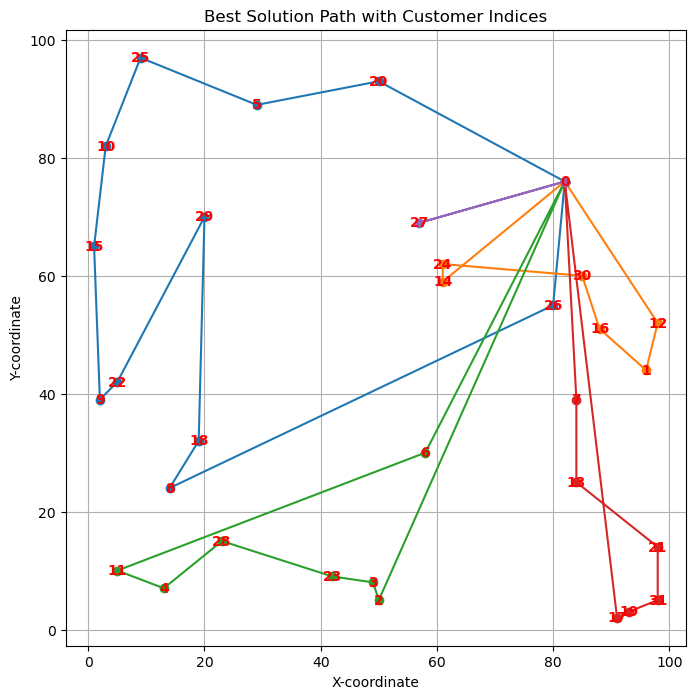

In [22]:
draw_path(cvrp_instance.customer_x, cvrp_instance.customer_y,best_solution)

In [13]:
import math
def calculate_total_length(customer_x, customer_y, path):
    total_length = 0.0

    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i + 1]

        x1, y1 = customer_x[current_node], customer_y[current_node]
        x2, y2 = customer_x[next_node], customer_y[next_node]

        # Calculate Euclidean distance
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_length += distance

    return total_length

In [14]:
total_length = calculate_total_length(cvrp_instance.customer_x, cvrp_instance.customer_y, best_solution)
print(total_length)

881.3194347949061
